In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from photoholmes.utils.image import read_jpeg_data, read_image

def plot_image(image, title="Image"):
    if isinstance(image, bytes):
        image = np.frombuffer(image, np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [4]:
def prepare_image(image):
    return torch.from_numpy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).transpose(2, 0, 1))


def ensure_jpeg(image):
    encode_param = [cv2.IMWRITE_JPEG_QUALITY, 95]

    success, encoded_img = cv2.imencode(".jpg", image, encode_param)
    if success:
        decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
        if decoded_img is not None:
            return prepare_image(decoded_img)

    return cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

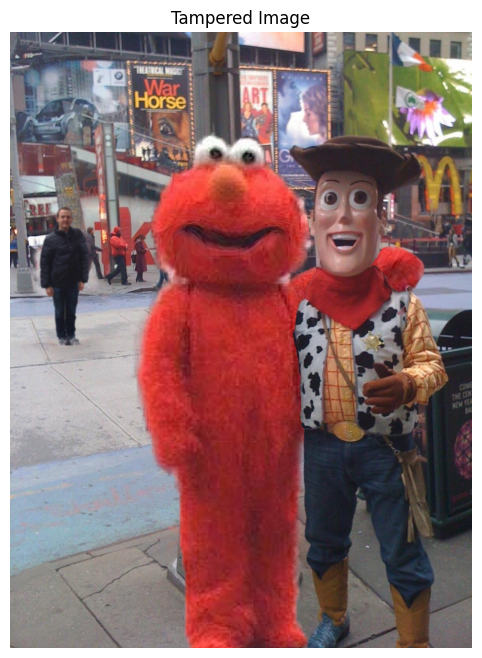

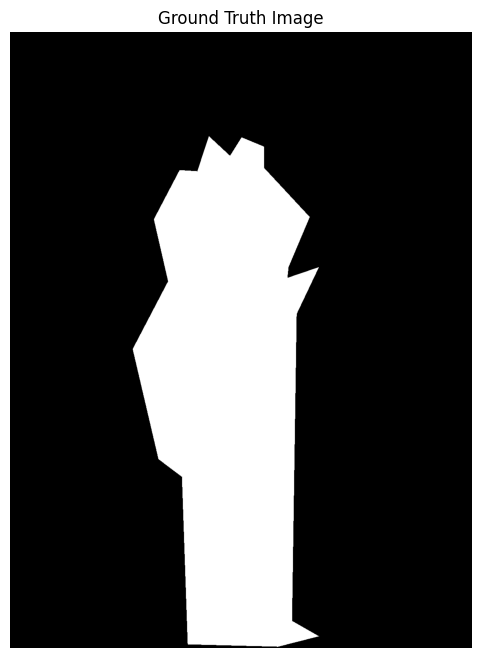

In [5]:
img_folder = "/home/nhat82125/ForgeryX-Server/example"
img_name = "im1_edit3"

tp_img_path = os.path.join(img_folder, f"{img_name}.jpg")
gt_img_path = os.path.join(img_folder, f"{img_name}.png")

# if not is_true_jpeg(tp_img_path):
#     converted_tp_img_path = convert_to_jpeg(tp_img_path)
#     tp_img_path = converted_tp_img_path

tp_img_cv = cv2.imread(tp_img_path)
tp_img = ensure_jpeg(tp_img_cv)

# tp_img = read_image(tp_img_path)
gt_img = read_image(gt_img_path)

plot_image(tp_img.permute(1, 2, 0).numpy(), "Tampered Image")
plot_image(gt_img.permute(1, 2, 0).numpy(), "Ground Truth Image")

In [6]:
from photoholmes.methods.catnet import CatNet, catnet_preprocessing

weight_path = "/home/nhat82125/photoholmes/weights/catnet/weights.pth"
device = "cuda"
arch_config = "pretrained"

weights = torch.load(weight_path, weights_only=False)

method = CatNet(
    arch_config=arch_config,
    weights=weights,
)

method.to_device(device)

WARNING -  CatNet is under a license that only allows research use. You can check the license inside the method folder's or at https://github.com/mjkwon2021/CAT-Net/blob/main/README.md#licence.If you use this method, you are agreeing to the terms of the license.


In [7]:
dct, qtables = read_jpeg_data(os.path.join(img_folder, f"{img_name}.jpg"))

image_data = {"image": tp_img, "dct_coefficients": dct, "qtables": qtables}
input = catnet_preprocessing(**image_data)

method.eval()

CatNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [8]:
with torch.no_grad():
    output = method.predict(**input)

/home/nhat82125/photoholmes/src/photoholmes/methods/catnet/method.py:354: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x1 = F.upsample(x[1], size=(x0_h, x0_w), mode="bilinear")
/home/nhat82125/photoholmes/src/photoholmes/methods/catnet/method.py:355: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x2 = F.upsample(x[2], size=(x0_h, x0_w), mode="bilinear")
/home/nhat82125/photoholmes/src/photoholmes/methods/catnet/method.py:356: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x3 = F.upsample(x[3], size=(x0_h, x0_w), mode="bilinear")


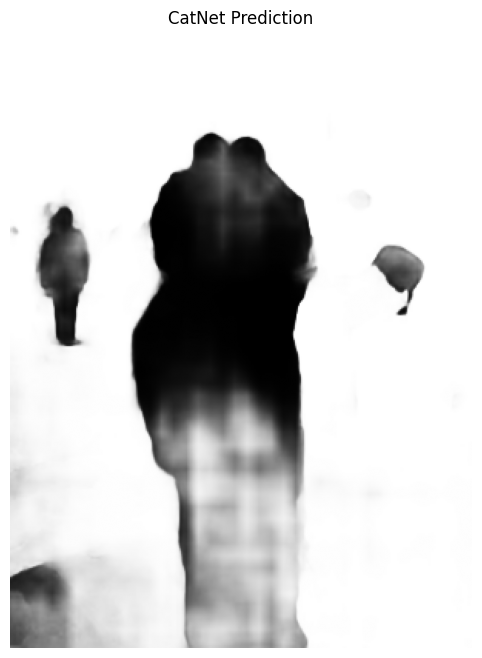

In [ ]:
plot_image(output[0].cpu().numpy(), "CatNet Prediction")

In [10]:
binary_image = np.array(output[0].cpu().numpy(), dtype=np.float32)

normalized_image = (binary_image - np.min(binary_image)) / \
    (np.max(binary_image) - np.min(binary_image))
heatmap = cv2.applyColorMap(
    np.uint8(255 * normalized_image), cv2.COLORMAP_JET)

cv2.imwrite("catnet.png", heatmap)

True

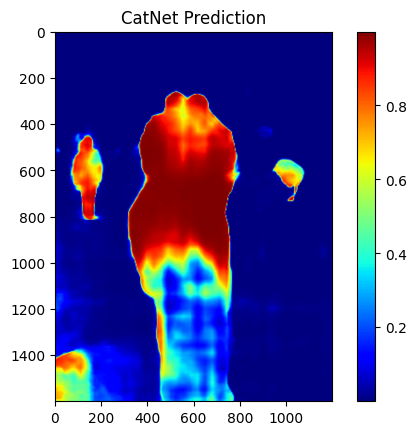

In [11]:
plt.imshow(output[0].cpu().numpy(), cmap='jet', interpolation='hamming')
plt.title('CatNet Prediction')
plt.colorbar()